In [1]:
# plot number of individuals per region as a Facet Graph

In [2]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np

from dotenv import load_dotenv
load_dotenv()
import os

import sqlite3

DB_PATH = os.getenv("DB_PATH")

conn = sqlite3.connect(DB_PATH)

In [3]:
# Years
df_ind = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
df_ind_year = df_ind[["individual_wikidata_id", "birthyear", "individual_name"]].drop_duplicates()
df_ind_year = df_ind_year[~df_ind_year['birthyear'].isna()]

# Individuals Regions
df_ind_regions = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
df_ind_regions = df_ind_regions[['individual_wikidata_id', 'region_name']].drop_duplicates()
df_ind_year["productive_year"] = df_ind_year["birthyear"] + 35
temporal_resolution = 10
df_ind_year["decade"] = df_ind_year["productive_year"].apply(lambda x: round(x / temporal_resolution) * temporal_resolution)
df_ind_year = df_ind_year[df_ind_year['decade']<=1890]


In [4]:
max(df_ind_year.productive_year)

1885.0

In [5]:
len(set(df_ind_regions.individual_wikidata_id))

164094

In [6]:

df_catalogs_id = pd.read_sql_query("SELECT * FROM individual_identifiers", conn)
df = pd.merge(df_ind_regions, df_ind_year, on = 'individual_wikidata_id')
df = pd.merge(df, df_catalogs_id, on = 'individual_wikidata_id')
df = df[['individual_wikidata_id', 'region_name', 'decade']].drop_duplicates()
df['score'] = 1

kept_individuals = pd.read_sql('SELECT * FROM individuals_kept', conn)
kept_individuals_list = list(kept_individuals['individual_wikidata_id'])
df = df[df['individual_wikidata_id'].isin(kept_individuals_list)]

In [7]:
len(set(df.individual_wikidata_id))

159745

In [8]:
len(set(df.individual_wikidata_id))

159745

In [9]:
df_group = df.groupby(['region_name', 'decade'])['score'].sum().reset_index()
df_group.to_sql('region_score',conn, if_exists = 'replace', index=False)
df_group.to_csv('results/df_region_score.csv')

In [10]:
# score for science
df_scientists = pd.read_sql_query("SELECT * FROM individual_occupations", conn)
df_scientists = df_scientists[df_scientists['occupations_category'].str.contains('science')]


top_scientific_occupations = df_scientists.occupations_name.value_counts()
top_scientific_occupations = top_scientific_occupations.head(50).index
occupations_to_remove = ['pedagogue', 'explorer', 'music pedagogue', 'land surveyor', 'music theorist', 'folklorist', 'conquistador', 'urban planner', 'settler']
filtered_occupation_list = [occupation for occupation in top_scientific_occupations if occupation not in occupations_to_remove]
df_scientists = df_scientists[df_scientists['occupations_name'].isin(filtered_occupation_list)]


list_scientists = list(set(df_scientists['individual_wikidata_id']))

df_scientists = df[df['individual_wikidata_id'].isin(list_scientists)]
df_group_science = df_scientists.groupby(['region_name', 'decade'])['score'].sum().reset_index()

df_group_science.to_sql('region_score_science',conn, if_exists = 'replace', index=False)
df_group_science.to_csv('results/df_region_score_science.csv')


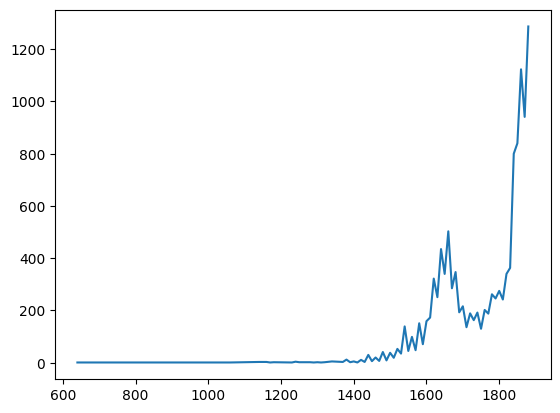

In [11]:
df_test = df_group[df_group['region_name']=='Low countries']

import matplotlib.pyplot as plt
plt.plot(df_test['decade'],df_test['score'])

#### Plot Score for every region

In [12]:
"""

import plotly.express as px
import plotly

df_fig = df.copy()
df_fig['log_cultural_score'] = np.log(1 + df_fig['score'])
df_fig['normalized_cultural_score'] = df_fig.groupby('region_name')['log_cultural_score'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df_fig = df_fig[df_fig['decade']<=1850]


fig = px.line(df_fig, 
              x="decade", 
              y="normalized_cultural_score", 
              facet_col="region_name", 
              facet_col_wrap=6, 
              width = 800, 
              height = 800, 
              template = 'simple_white')


fig.update_xaxes(tickmode='linear', dtick=200)
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True))
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))

for region_name in df['region_name'].unique():
    fig.update_xaxes(title_text='decade', col=region_name)
    
fig.show()
#plotly.offline.plot(fig)


"""

'\n\nimport plotly.express as px\nimport plotly\n\ndf_fig = df.copy()\ndf_fig[\'log_cultural_score\'] = np.log(1 + df_fig[\'score\'])\ndf_fig[\'normalized_cultural_score\'] = df_fig.groupby(\'region_name\')[\'log_cultural_score\'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))\ndf_fig = df_fig[df_fig[\'decade\']<=1850]\n\n\nfig = px.line(df_fig, \n              x="decade", \n              y="normalized_cultural_score", \n              facet_col="region_name", \n              facet_col_wrap=6, \n              width = 800, \n              height = 800, \n              template = \'simple_white\')\n\n\nfig.update_xaxes(tickmode=\'linear\', dtick=200)\nfig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True))\nfig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))\n\nfor region_name in df[\'region_name\'].unique():\n    fig.update_xaxes(title_text=\'decade\', col=region_name)\n    \nfig.show()\n#plotly.offline.plot(fig)\n\n\n'